In [1]:

import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} # surprise je promenjen sa 8 na 0
DATA_PATH = 'C:/Users/Saransh/Desktop/Research Team/data/RAVDESS/audio_speech_actors_01-24/'
SAMPLE_RATE = 48000
import torch
import torch.nn as nn
import torch.nn.functional

In [4]:
import torch
import torch.nn as nn
# BATCH FIRST TimeDistributed layer
class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)
        # squash samples and timesteps into a single axis
        elif len(x.size()) == 3: # (samples, timesteps, inp1)
            x_reshape = x.contiguous().view(-1, x.size(2))  # (samples * timesteps, inp1)
        elif len(x.size()) == 4: # (samples,timesteps,inp1,inp2)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3)) # (samples*timesteps,inp1,inp2)
        else: # (samples,timesteps,inp1,inp2,inp3)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3),x.size(4)) # (samples*timesteps,inp1,inp2,inp3)
            
        y = self.module(x_reshape)
        
        # we have to reshape Y
        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(1))  # (samples, timesteps, out1)
        elif len(x.size()) == 4:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2)) # (samples, timesteps, out1,out2)
        else:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2),y.size(3)) # (samples, timesteps, out1,out2, out3)
        return y
class HybridModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            TimeDistributed(nn.Conv2d(in_channels=1,
                                   out_channels=16,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(16)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=2, stride=2)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 2. conv block
            TimeDistributed(nn.Conv2d(in_channels=16,
                                   out_channels=32,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(32)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 3. conv block
            TimeDistributed(nn.Conv2d(in_channels=32,
                                   out_channels=64,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(64)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 4. conv block
            TimeDistributed(nn.Conv2d(in_channels=64,
                                   out_channels=128,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(128)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4))
        )
        # LSTM block
        hidden_size = 64
        self.lstm = nn.LSTM(input_size=128,hidden_size=hidden_size,bidirectional=False, batch_first=True) 
        self.dropout_lstm = nn.Dropout(p=0.3)
        # Linear softmax layer
        self.out_linear = nn.Linear(hidden_size,num_emotions)
    def forward(self,x):
        conv_embedding = self.conv2Dblock(x)
        conv_embedding = torch.flatten(conv_embedding, start_dim=2) # do not flatten batch dimension and time
        lstm_embedding, (h,c) = self.lstm(conv_embedding)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        # lstm_embedding (batch, time, hidden_size)
        lstm_output = lstm_embedding[:,-1,:] 
        output_logits = self.out_linear(lstm_output)
        output_softmax = nn.functional.softmax(output_logits,dim=1)
        return output_logits, output_softmax

In [6]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = HybridModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn_lstm_model1.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'cnn_lstm_model1.pt')))
model.eval()

Model is loaded from C:\Users\Saransh\Desktop\Speech-Emotion-Classification-with-PyTorch\notebooks\models\cnn_lstm_model1.pt


HybridModel(
  (conv2Dblock): Sequential(
    (0): TimeDistributed(
      (module): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimeDistributed(
      (module): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): TimeDistributed(
      (module): ReLU()
    )
    (3): TimeDistributed(
      (module): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): TimeDistributed(
      (module): Dropout(p=0.4, inplace=False)
    )
    (5): TimeDistributed(
      (module): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (6): TimeDistributed(
      (module): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (7): TimeDistributed(
      (module): ReLU()
    )
    (8): TimeDistributed(
      (module): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (9): TimeDistributed(
      (module):

In [7]:
data = pd.DataFrame(columns=['Emotion', 'Emotion intensity','Path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join('/kaggle/input/',dirname, filename)
        identifiers = filename.split('.')[0].split('_')
        print(identifiers[2].len)
        emotion = (int(identifiers[2]))
        if emotion == 8:
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal' 
        else:
            emotion_intensity = 'strong'
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        data = data.append({"Emotion": emotion,
                            "Emotion intensity": emotion_intensity,
                            "Gender": gender,
                            "Path": file_path
                             },
                             ignore_index = True
                          )

IndexError: list index out of range

In [41]:
print("number of files is {}".format(len(data)))
data.head()

number of files is 0


,Emotion,Emotion intensity,Path


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8,) and arg 1 with shape (0,).

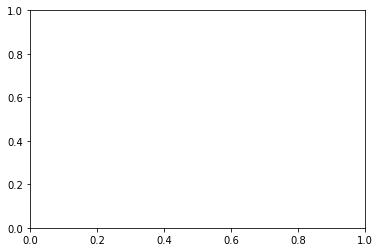

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(8), height=data['Emotion'].value_counts())
ax.set_xticks(ticks=range(8))
ax.set_xticklabels([EMOTIONS[i] for i in range(8)],fontsize=10)
ax.set_xlabel('Emotion')
ax.set_ylabel('Number of examples')

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (0,).

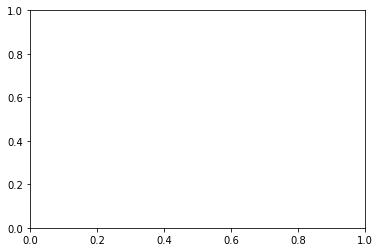

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Emotion intensity'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

In [43]:
mel_spectrograms = []
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    print("\r Processed {}/{} files".format(i,len(data)),end='')
signals = np.stack(signals,axis=0)

ValueError: need at least one array to stack

In [44]:
X = signals
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

TypeError: list indices must be integers or slices, not tuple

In [45]:
device ='cuda'
X_test= 
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

SyntaxError: invalid syntax (2521717787.py, line 2)